In [31]:
import pandas as pd
import numpy as np
import darts
from darts.models.forecasting.arima import ARIMA
from darts import TimeSeries
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


# loading Data

In [32]:
df = pd.read_csv('../ProcessedData/United States.csv')
df

,Country,Fiscal Year,Fiscal Week,Global DGV NS Visits,year,week_number,date
0,United States,2019-FY,2019-W01,1170974,2019,1,2019-01-07
1,United States,2019-FY,2019-W02,1178535,2019,2,2019-01-14
2,United States,2019-FY,2019-W03,1199019,2019,3,2019-01-21
3,United States,2019-FY,2019-W04,1136948,2019,4,2019-01-28
4,United States,2019-FY,2019-W05,1134891,2019,5,2019-02-04
...,...,...,...,...,...,...,...
283,United States,2024-FY,2024-W23,1014805,2024,23,2024-06-10
284,United States,2024-FY,2024-W24,945077,2024,24,2024-06-17
285,United States,2024-FY,2024-W25,909239,2024,25,2024-06-24
286,United States,2024-FY,2024-W26,886430,2024,26,2024-07-01


# ARIMA Model


## Box-Jenkins Framework
The **Box-Jenkins** method is a statistical technique used for time series analysis and forecasting. The approach starts with the assumption that the process that generated the time series can be approximated using an **ARMA model** if it is stationary or an **ARIMA model** if it is non-stationary.

The **Box-Jenkins** method applies autoregressive moving average (ARMA) or autoregressive integrated moving average (ARIMA) models to find the best fit of a time-series model to past values of a time series2. The model can analyze several different types of time series data for forecasting purposes3.

## ARIMA Model Pipeline
**Autoregressive Integrated Moving Average** (ARIMA) Model
* autoregressive models: AR(p)
* moving average models: MA(q)
* mixed autoregressive moving average models: ARMA(p, q)
* integration models: ARIMA(p, d, q)

## Stationary Test
* **What is stationary Data ?**    
Stationary data refers to time series data that mean and variance do not vary across time. The data is considered non-stationary if there is a strong trend or seasonality observed from the data.
* **Why we need stationary Data for ARIMA Model**  
ARIMA models rely on the assumption that the time series being modeled is stationary. Therefore that assumption needs to hold if you want to use these models. The ARIMA model uses differenced data to make the data stationary, which means there’s a consistency of the data over time. This function removes the effect of trends or seasonality, such as market or economic data. We make the data stationary only in case of ARIMA because the ARIMA model looks at the past data to predict future values.

In [33]:

def adfuller_test(values):
    result=adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")


In [34]:
adfuller_test(df['Global DGV NS Visits'])

ADF Test Statistic : -5.078705540867806
p-value : 1.5469084360210878e-05
#Lags Used : 4
Number of Observations Used : 283
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


# Spliting Data into Training & Testing Data

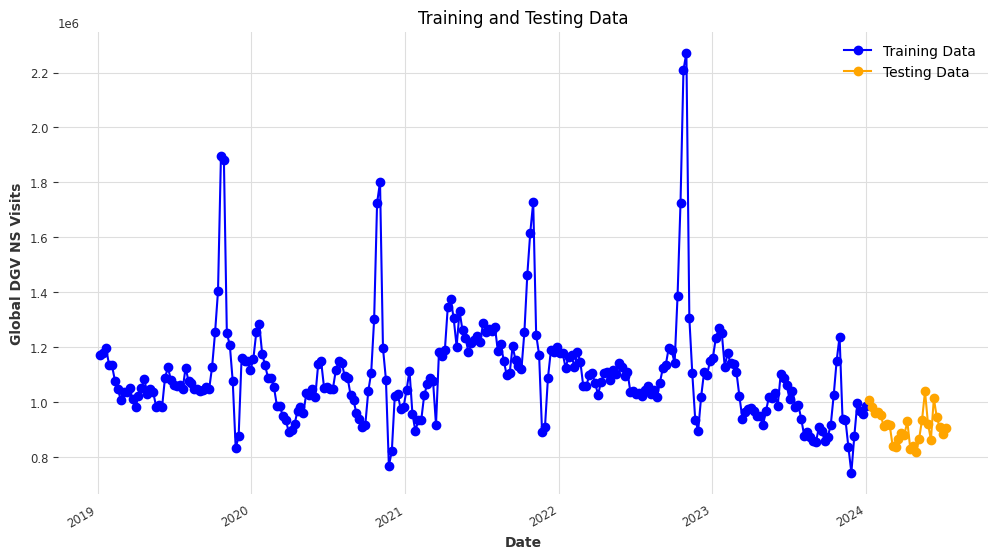

In [35]:
series = TimeSeries.from_dataframe(df, "date", "Global DGV NS Visits")
split_point = pd.Timestamp('2024-01-01')

train_series , test_series = series.split_after(split_point)


# Set the figure size and style
plt.figure(figsize=(12, 6))
# Plot the training and testing data
train_series.plot(label='Training Data', color='blue', linewidth=1.5,marker='o')
test_series.plot(label='Testing Data', color='orange', linewidth=1.5,marker='o')

# Add title and labels
plt.title('Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Global DGV NS Visits')

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


## Inspect Seasonality

In [36]:
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(train_series, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.


## Auto Correlation plot
The autocorrelation function (ACF) is used to identify the order of ARIMA models. The ACF plot shows the correlation between the time series and its lagged version. The lag at which the ACF plot crosses the upper confidence interval for the first time is considered as the order of the **MA** component of the ARIMA model. Similarly, if the ACF plot decays slowly, it indicates that there is a high degree of autocorrelation in the time series, which means that an AR component should be included in the ARIMA model.

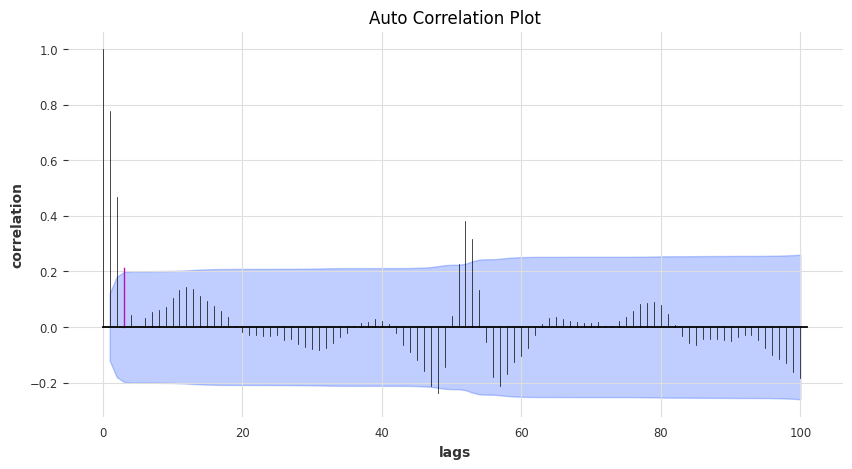

In [37]:
from darts.utils.statistics import plot_acf,plot_pacf


plot_acf(train_series, m=3, max_lag=100,  fig_size=(10, 5), axis=None, default_formatting=True)
plt.xlabel('lags')
plt.ylabel('correlation')
plt.title('Auto Correlation Plot')
plt.show()

## Partial Auto Correlation plot
The partial autocorrelation function (PACF) is also used to identify the order of ARIMA models. The PACF plot shows the correlation between the time series and its lagged version, but with the influence of the intermediate lags removed. The lag at which the PACF plot crosses the upper confidence interval for the first time is considered as the order of the **AR** component of the ARIMA model.

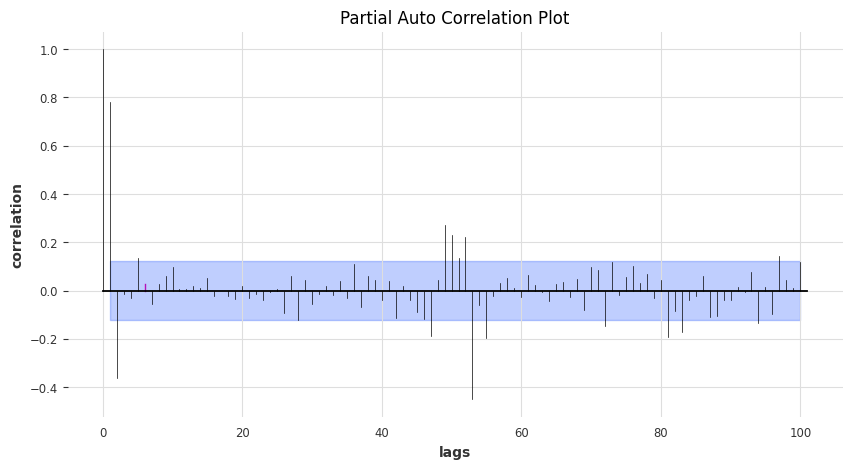

In [38]:
from darts.utils.statistics import plot_acf,plot_pacf
plot_pacf(train_series, m=6, max_lag=100,  fig_size=(10, 5), axis=None, default_formatting=True)

plt.xlabel('lags')
plt.ylabel('correlation')
plt.title('Partial Auto Correlation Plot')
plt.show()

# ARIMA Model Fitting

In [39]:
# Custom feature based on years since 2020
custom_feature = lambda idx: (idx.year - 2019)

arima_model = ARIMA(
    p=5,
    d=1, 
    q=3, 
    seasonal_order=(5, 1, 3, 7), 
    trend=None, 
    random_state=1999,
    add_encoders={
        'cyclic': {'future': ['month']},
        'datetime_attribute': {'future': ['hour', 'dayofweek']},
        'position': {'future': ['relative']},
        'custom': {'future': [custom_feature]},
    }
)

arima_model.fit(train_series)

horizan = len(test_series)


/home/iffi/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/iffi/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/iffi/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Results of ARIMA Model


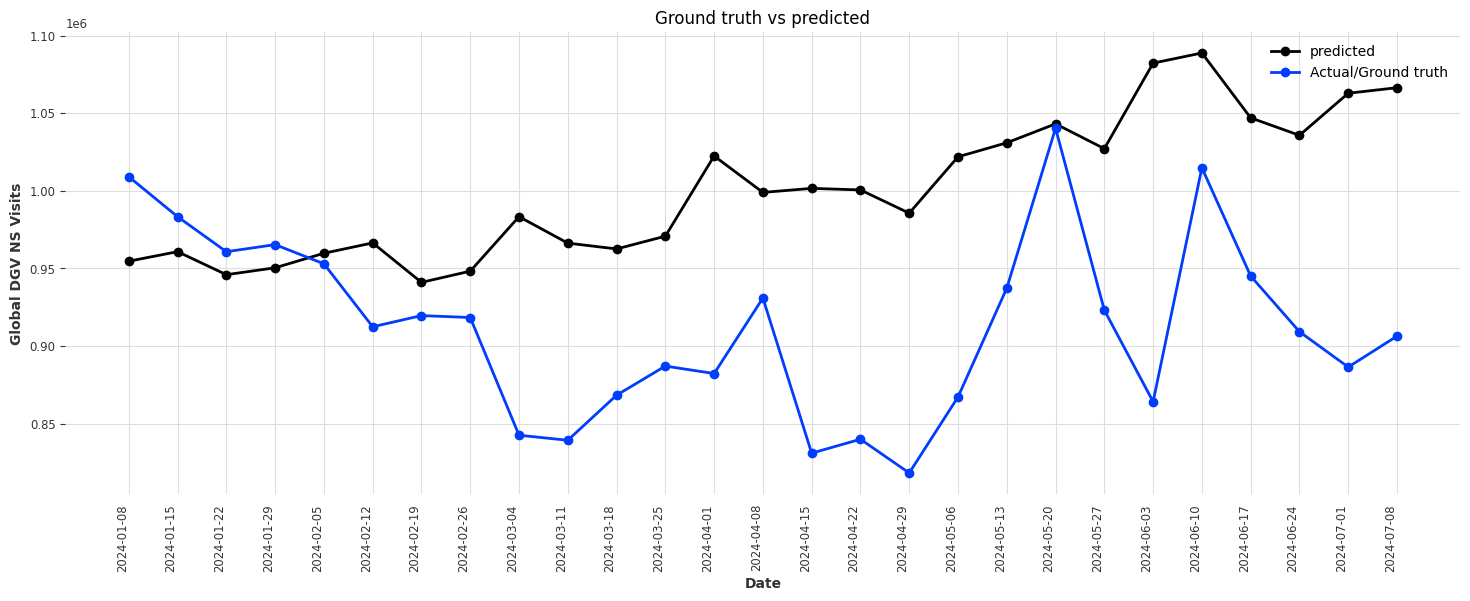

In [41]:
plt.figure(figsize=(18, 6))
forcast_arima = arima_model.predict(horizan)
arima_model.predict(horizan).plot(marker='o',label='predicted')
test_series.plot(marker='o',label='Actual/Ground truth')
# Add title and labels
plt.title('Ground truth vs predicted')
plt.xlabel('Date')
plt.ylabel('Global DGV NS Visits')
plt.xticks(forcast_arima.time_index, forcast_arima.time_index.strftime('%Y-%m-%d'), rotation=90)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


## Statistical Results

In [42]:
actual_values = test_series.pd_dataframe()['Global DGV NS Visits'].values
predicted_values = forcast_arima.pd_dataframe()['Global DGV NS Visits'].values

# Calculate MAE
mae = np.round(np.mean(np.abs(actual_values - predicted_values)),2)

# Calculate MAPE
mape = np.round(np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100,2)

print("Mean Absolute Error:", mae)
print("MAPE Percentage Error :", mape)


Mean Absolute Error: 95664.42
MAPE Percentage Error : 10.83


In [43]:
results_arima_model = {
}
results_arima_model['ActualValues'] =  actual_values
results_arima_model['PredictedValuues'] =  predicted_values

pd.DataFrame.from_dict(results_arima_model).to_csv(f"../Results/arima_results_MAE_{mae}_MAPE_{mape}.csv",index=False)

# XGBModel

In [23]:
from darts.models.forecasting.xgboost import XGBModel

xgb_model =XGBModel(lags=10,
                output_chunk_length=15,
                random_state=1999,
                multi_models=True,
                lags_future_covariates=None,
                lags_past_covariates=None
                
                
            )
xgb_model.fit(train_series)


XGBModel(lags=10, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=15, add_encoders=None, likelihood=None, quantiles=None, random_state=1999, multi_models=True, use_static_covariates=True)

# Result of XGBModel

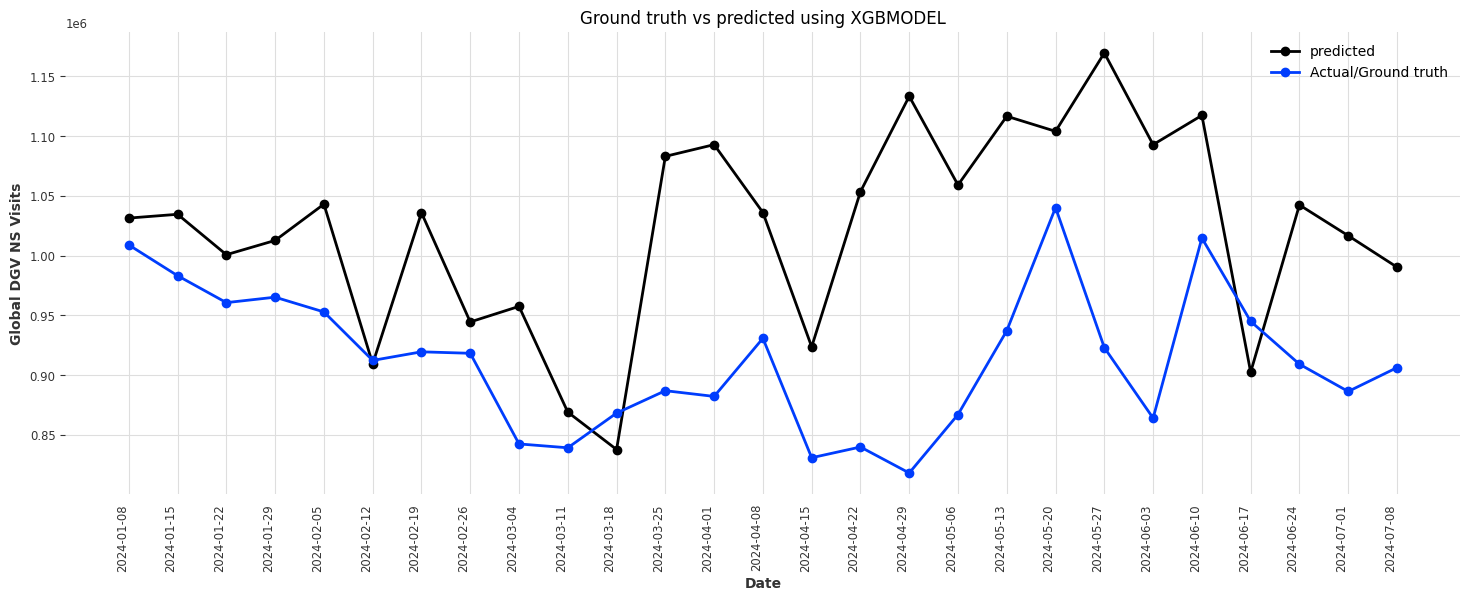

In [24]:
plt.figure(figsize=(18, 6))
forecast = xgb_model.predict(horizan)
xgb_model.predict(horizan).plot(marker='o',label='predicted')
test_series.plot(marker='o',label='Actual/Ground truth')
# Add title and labels
plt.title('Ground truth vs predicted using XGBMODEL')
plt.xlabel('Date')
plt.ylabel('Global DGV NS Visits')
# Add grid lines
plt.grid(True)
plt.xticks(forecast.time_index, forecast.time_index.strftime('%Y-%m-%d'), rotation=90)

# Add legend
plt.legend()

# Display the plot
plt.show()


# Statistical Results

In [27]:
actual_values_xgb = test_series.pd_dataframe()['Global DGV NS Visits'].values
predicted_values_xgb = forecast.pd_dataframe()['Global DGV NS Visits'].values

# Calculate MAE
mae_xgb = np.round(np.mean(np.abs(actual_values_xgb - predicted_values_xgb)),2)

# Calculate MAPE
mape_xgb = np.round(np.mean(np.abs((actual_values_xgb - predicted_values_xgb) / actual_values_xgb)) * 100,2)

print("Mean Absolute Error:", mae_xgb)
print("MAPE Percentage Error:", mape_xgb)


Mean Absolute Error: 115159.3
MAPE Percentage Error: 12.92


In [29]:
results_xgb_model = {
}
results_xgb_model['ActualValues'] =  actual_values_xgb
results_xgb_model['PredictedValuues'] =  predicted_values_xgb

pd.DataFrame.from_dict(results_xgb_model).to_csv(f"../Results/xgb_results_MAE_{mae_xgb}_MAPE_{mape_xgb}.csv",index=False)

In [84]:
# %%shell
# jupyter nbconvert --to html  modeling_version_01.ipynb

UsageError: Cell magic `%%shell` not found.


In [1]:
# pip freeze > requirements.txt


Note: you may need to restart the kernel to use updated packages.
